In [152]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc


npr = np.array
softmax = sc.special.softmax


images0: (1000, 100, 100)
images: (1000, 100, 100)
[104]
[300]


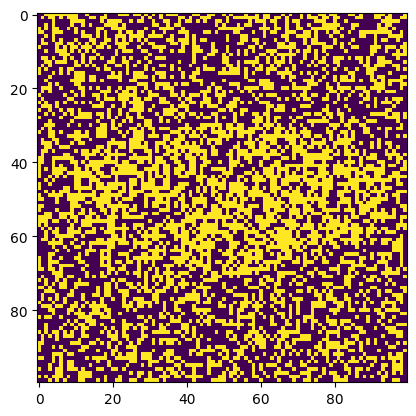

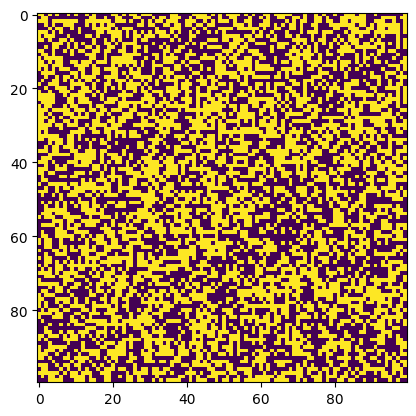

In [153]:
# open images
images0 = np.load('images0.npy')
images = np.load('images.npy')
print('images0:', images0.shape)
print('images:', images.shape)
random_im0 = np.random.choice(images0.shape[0], 1)
print(random_im0)
random_im = np.random.choice(images.shape[0], 1)
print(random_im)
plt.imshow(images0[random_im0][0])
plt.show()
plt.imshow(images[random_im][0])
plt.show()


In [154]:
# task01 functions
def get_eta_func(etas: np.ndarray[int]):
    return np.vectorize(lambda x: etas[1] if x else etas[0], otypes=[float])

def estimate_s(im, etas):
    return (im*(etas[1] - etas[0]) + np.log(1+np.exp(etas[0]))  - np.log(1+np.exp(etas[1])) > 0).astype(int)

def estimate_eta(avg_image, s):
    sss = npr([s==0, s==1])
    # print(avg_image)
    # print(avg_image*sss)
    xs = np.sum(np.sum(avg_image*sss, axis=-1), axis=-1)
    # print(xs.shape)
    sum_s = np.sum(s)
    n0 = s.size - sum_s
    n1 = sum_s
    n = npr([n0, n1])
    new_eta = np.log(xs) - np.log(n - xs)
    return new_eta

def log_p(avg_image, s, etas):
    logp = np.sum(avg_image*s) - np.sum(1-s)*np.log(1+np.exp(etas[0])) - np.sum(s)*np.log(1+np.exp(etas[1]))
    return logp

def shape_mle(avg_image, etas_init):
    """
    equation: x_avg^T @ 
    """
    # init
    # s = np.random.randint(2, size=avg_image.shape)
    s_estimate = np.zeros(avg_image.shape)
    last_etas = np.zeros(2)
    eta_estimate = etas_init
    logp = 0
    for i in range(1000):
        last_etas = eta_estimate
        last_s = s_estimate
        s_estimate = estimate_s(avg_image, eta_estimate)
        eta_estimate = estimate_eta(avg_image, s_estimate)
        eta_func = get_eta_func(eta_estimate)
        last_logp = logp
        logp = log_p(avg_image, s_estimate, eta_estimate)
        # print('\rlog_p:', logp, end='')
        last_s = s_estimate
        last_etas = eta_estimate
        if np.abs(logp - last_logp) < 1e-5:
            # print('Finished in', i+1, 'iterations')
            break
        # print('ds:', np.sum(last_s)-np.sum(s_estimate))
        # print('detas:', eta_estimate - last_etas)
        # print(eta_estimate)
    return s_estimate, eta_estimate

etas [-0.40569647  0.40651866]


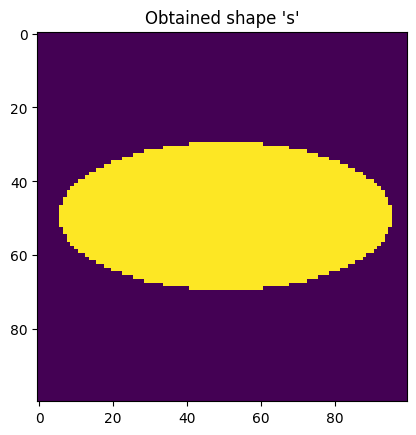

In [155]:
# run task 1
avg_image0 = np.mean(images0, axis=0)
etas_init0 = estimate_eta(avg_image0, avg_image0>0.5)
# etas_init = np.array([0.2, 0.8])  # converges in first step 
# print('etas_init:', etas_init)
s0, etas0 = shape_mle(avg_image0, etas_init0)
# print('s sum:', np.sum(s))
print('etas', etas0)
# plt.imshow(avg_image)
# plt.show()
plt.imshow(s0)
plt.title('Obtained shape \'s\'')
plt.show()

In [156]:
# task 02 functions
def get_rots_s(s, transpose=False):
    if transpose:
        return npr([np.rot90(s, k) for k in range(4)])
    else:
        return npr([np.rot90(s, -k) for k in range(4)])


def posterior_pose_probs(ims, s, pi):
    rots = get_rots_s(s)
    x = np.repeat(ims[:, np.newaxis], repeats=4, axis=1)
    argsss = np.sum(np.sum(x*rots, axis=-1), axis=-1) + np.log(pi)
    return softmax(argsss, axis=1)


def get_pi(alphas):
    return np.mean(alphas, axis=0)

def get_phi(ims, alphas):
    rot_ims = np.zeros((ims.shape[0], 4, ims.shape[1], ims.shape[2]))
    x = np.repeat(ims[:, np.newaxis], repeats=4, axis=1)
    rot_ims = npr(list(map(lambda x: get_rots_s(x, transpose=True), ims)))
    # the lines below should work as i imagine
    tmp_a = alphas[..., np.newaxis, np.newaxis]
    res = rot_ims * tmp_a  # seems alright
    res = np.mean(np.sum(res, axis=1), axis=0)
    return res


def run_EM(ims, max_iters=100):
    mean_im = np.mean(ims, axis=0)
    s_init = mean_im > 0.5
    pi_init = np.ones(4) / 4
    etas_init = estimate_eta(mean_im, s_init)

    cur_etas = etas_init
    cur_s = s_init
    cur_pi = pi_init
    best_score = -float('inf')
    last_score = -float('inf')
    score = -float('inf')
    for i in range(max_iters):
        # E step
        alphas = posterior_pose_probs(ims, cur_s, cur_pi)
        # print('alphas:', alphas.shape)
        # M step
        phi = get_phi(ims, alphas)
        # if i % 5 == 0 or i%4 == 0:
        #     plt.imshow(phi)
        #     plt.show()
        #     plt.imshow(cur_s)
        #     plt.show()
        cur_s, cur_etas = shape_mle(phi, cur_etas)
        cur_pi = get_pi(alphas)
        last_score = score
        score = log_p(phi, cur_s, cur_etas) + np.mean(np.sum(alphas*cur_pi, axis=1))
        print('score:', score, ' best_score:', best_score)
        # has not improved, nay perhaps even worsened
        # np.abs(logp - last_logp) < 1e-5
        if np.abs(score-last_score) < 1e-5:  
            break
        if score > best_score:
            best_score = score
            best_s = cur_s
            best_etas = cur_etas
            best_pi = cur_pi
        

    return best_s, best_etas, best_pi


score: -4366.116744982394  best_score: -inf
score: -4289.0402338854965  best_score: -4366.116744982394
score: -4061.1259569862664  best_score: -4289.0402338854965
score: -4061.478083478153  best_score: -4061.1259569862664
score: -4061.478083478153  best_score: -4061.1259569862664
etas: [-0.20144004  0.19916591] pi: [0.30061295 0.20048585 0.19999996 0.29890124]


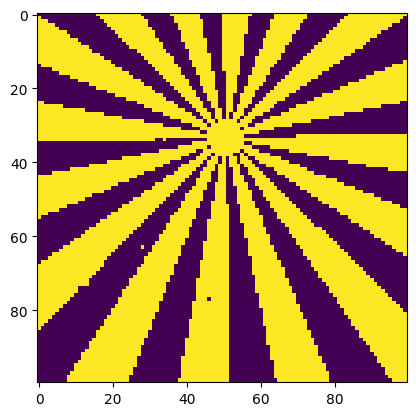

In [157]:
# run task 02
# s_init = np.mean(images, axis=0) > 0.5
# plt.imshow(s_init)
# plt.show()
# alphas_init = posterior_pose_probs(images, s_init, np.ones(4)/4)

# phi = get_phi(images, alphas_init)
# print('s_init:', s_init.shape)
# print('phi:', phi.shape)
# etas_init = estimate_eta(phi, s_init)
# s, etas = shape_mle(phi, etas_init)
# plt.imshow(s)
# plt.show()
# # print(phi.shape)
s, etas, pi = run_EM(images, max_iters=50)
print('etas:', etas, 'pi:', pi)
plt.imshow(s)
plt.show()